In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [11]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    return train_data, train_label, test_data, test_label

train_data, train_label, test_data, test_label = read_bci_data()

train_data.shape

train_label.shape

(1080,)

In [12]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
device

'cuda'

In [13]:
# Convert numpy.ndarray to tensor with same type 
train_data = torch.Tensor(train_data)
train_label = torch.LongTensor(train_label)
test_data = torch.Tensor(test_data)
test_label = torch.LongTensor(test_label)

train_dataset = TensorDataset(train_data, train_label)
test_dataset = TensorDataset(test_data, test_label)

batch_size = 1080
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# , num_workers=14, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , num_workers=14, pin_memory=True)

len(train_loader) # 10

1

In [14]:
# Step 1: Define the neural network architecture
class DeepConvNet(nn.Module):
    def __init__(self, activation_function):
        super().__init__()       
        
        if activation_function == "ReLU":
            self.activation = nn.ReLU()
        elif activation_function == "LeakyReLU":
            self.activation = nn.LeakyReLU()
        elif activation_function == "ELU":
            self.activation = nn.ELU(alpha=1.0)
        
        # Stacking multiple layers sequentially
        self.firstConv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=25, kernel_size=(1, 5)),
            nn.Conv2d(in_channels=25, out_channels=25, kernel_size=(2, 1)),
            nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )

        self.secondConv = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 5)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.1),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )

        self.thirdConv = nn.Sequential(
            nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(1, 5)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.1),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        
        self.fourthConv = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(1, 5)),
            nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.1),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        
        self.flatten = nn.Flatten() # (1, 200, 2, 367)
        self.dense = nn.Sequential(
            # mat1 and mat2 shapes (108x8600 and 400x2)
            nn.Linear(8600, 2), # define a fully connected (dense) layer in a neural network
        )
        
    def forward(self, x):
        feature = self.firstConv(x)
        feature = self.secondConv(feature)
        feature = self.thirdConv(feature)
        feature = self.fourthConv(feature)
        flatten = self.flatten(feature)
        pred = self.dense(flatten)
        return pred

In [15]:
# Step 2: Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

ReLU_train_acc = []
ReLU_test_acc = []
LeakyReLU_train_acc = []
LeakyReLU_test_acc = []
ELU_train_acc = []
ELU_test_acc = []

total_cnt = len(train_loader.dataset)

num_epoch = 1201

torch.manual_seed(48763)

def epoch_loop(activation_function, num_epoch, train_loader, test_loader, model, loss_fn, optimizer):
    best_acc = 0
    for e in range(num_epoch):
        acc1 = train(train_loader, model, loss_fn, optimizer)
        acc2 = test(test_loader, model, loss_fn)
        if (e % (num_epoch//10)) == 0:
            print(f'Epoch: {e:5}, acc1:{acc1:.2f}%')
            print(f'Epoch: {e:5}, acc2:{acc2:.2f}%')
        if acc2 > best_acc:
            best_acc = acc2
            torch.save(model.state_dict(), "DeepConvNet_" + str(activation_function) + ".pth")
            '''
            print("Model state dict:")
            for param_tensor in model.state_dict():
                print(param_tensor, "\t", model.state_dict()[param_tensor])
            print("Model save")
            '''
        if (e+1) == num_epoch:
            print(f'{activation_function} best acc: {best_acc:.2f}%')
            
def train(train_loader, model, loss_fn, optimizer):
    model.train() 
    match_train_cnt = 0

    for i, (train_data, train_label) in enumerate(train_loader): 
        train_data = train_data.to(device)
        train_label = train_label.to(device)

        output = model(train_data)
        loss = loss_fn(output, train_label)

        pred = torch.max(output, dim=1) 
        match_train_cnt += (pred[1] == train_label).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc1 = match_train_cnt / total_cnt * 100

    if activation_function == 'ReLU':
        ReLU_train_acc.append(acc1.item())
    elif activation_function == 'LeakyReLU':
        LeakyReLU_train_acc.append(acc1.item())
    else:
        ELU_train_acc.append(acc1.item())
        
    return acc1
        
def test(test_loader, model, loss_fn):
    # Step 5: Testing loop
    model.eval()
    match_test_cnt = 0
    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):   
            test_data = test_data.to(device)
            test_label = test_label.to(device)
            output = model(test_data)
            pred = torch.max(output, dim=1)
            match_test_cnt += (pred[1] == test_label).sum()

        acc2 = match_test_cnt / total_cnt * 100

    if activation_function == 'ReLU':
        ReLU_test_acc.append(acc2.item())
    elif activation_function == 'LeakyReLU':
        LeakyReLU_test_acc.append(acc2.item())
    else:
        ELU_test_acc.append(acc2.item())
    
    return acc2

In [16]:
for activation_function in ["ReLU", "LeakyReLU", "ELU"]:
    model = DeepConvNet(activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    epoch_loop(activation_function, num_epoch, train_loader, test_loader, model, loss_fn, optimizer)

Epoch:     0, acc1:52.04%
Epoch:     0, acc2:50.00%
Epoch:   120, acc1:78.98%
Epoch:   120, acc2:77.13%
Epoch:   240, acc1:85.37%
Epoch:   240, acc2:80.65%
Epoch:   360, acc1:87.96%
Epoch:   360, acc2:82.13%
Epoch:   480, acc1:90.83%
Epoch:   480, acc2:82.13%
Epoch:   600, acc1:92.50%
Epoch:   600, acc2:82.59%
Epoch:   720, acc1:94.44%
Epoch:   720, acc2:83.89%
Epoch:   840, acc1:95.74%
Epoch:   840, acc2:83.61%
Epoch:   960, acc1:96.20%
Epoch:   960, acc2:83.89%
Epoch:  1080, acc1:96.11%
Epoch:  1080, acc2:84.44%
Epoch:  1200, acc1:96.76%
Epoch:  1200, acc2:84.35%
ReLU best acc: 85.09%
Epoch:     0, acc1:49.81%
Epoch:     0, acc2:50.00%
Epoch:   120, acc1:80.83%
Epoch:   120, acc2:78.52%
Epoch:   240, acc1:87.41%
Epoch:   240, acc2:80.09%
Epoch:   360, acc1:91.57%
Epoch:   360, acc2:80.46%
Epoch:   480, acc1:91.39%
Epoch:   480, acc2:81.85%
Epoch:   600, acc1:93.06%
Epoch:   600, acc2:81.39%
Epoch:   720, acc1:95.37%
Epoch:   720, acc2:80.93%
Epoch:   840, acc1:96.48%
Epoch:   840, ac

In [17]:
for activation_function in ["ReLU", "LeakyReLU", "ELU"]:
    model = DeepConvNet(activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    filename =  "DeepConvNet_" + str(activation_function) + ".pth"
    model.load_state_dict(torch.load(filename))
    model.eval()
    best_acc = test(test_loader, model, loss_fn)
    print(f'{activation_function} acc: {best_acc:.2f}%')

ReLU acc: 85.09%
LeakyReLU acc: 83.43%
ELU acc: 82.87%


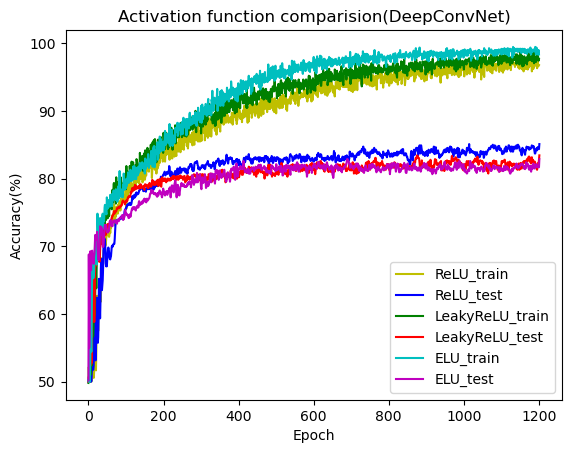

ReLU acc: 85.09%, LeakyReLU acc: 83.43%, ELU acc: 82.87%


In [18]:
def show_result():
    max_ReLU_acc = 0
    max_LeakyReLU_acc = 0
    max_ELU_acc = 0
    for i in range(num_epoch):
        max_ReLU_acc = max(max_ReLU_acc, ReLU_test_acc[i])
        max_LeakyReLU_acc = max(max_LeakyReLU_acc, LeakyReLU_test_acc[i])
        max_ELU_acc = max(max_ELU_acc, ELU_test_acc[i])
    
    plt.title('Activation function comparision(DeepConvNet)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')

    plt.plot(ReLU_train_acc, label = 'ReLU_train', color = 'y')
    plt.plot(ReLU_test_acc, label = 'ReLU_test', color = 'b')
    plt.plot(LeakyReLU_train_acc, label = 'LeakyReLU_train', color = 'g')
    plt.plot(LeakyReLU_test_acc, label = 'LeakyReLU_test', color = 'r')
    plt.plot(ELU_train_acc, label = 'ELU_train', color = 'c')
    plt.plot(ELU_test_acc, label = 'ELU_test', color = 'm')
    
    plt.legend()
    plt.show()
    
    print(f'ReLU acc: {max_ReLU_acc:.2f}%, LeakyReLU acc: {max_LeakyReLU_acc:.2f}%, ELU acc: {max_ELU_acc:.2f}%')

show_result()